# Midterm

Paper: PMID 27667667
Data link (available in paper): https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061

From E-MTAB-5061.idf.txt:
Format of the datafile ‘pancreas_refseq_rpkms_counts_3514sc.txt’: The file contains both the normalized rpkm values and the raw read counts for each sample. Columns correspond to samples and rows to genes. The first line of the file (starting with: #samples) contains the sample IDs to be used as column labels for both the rpkm and counts. The columns of the rpkm and the counts have the same order with the sample IDs. Columns 1:3514 correspond to rpkm values, Columns 3515:7028 correspond to read counts. Rows 1:26179 correspond to data for RefSeq genes, Rows 26180:26271 correspond to data for the 92 external RNA spike-in controls (ERCCs), Row 26272 (last) contains data for ‘eGFP’.

In [41]:
library(dplyr)
library(Seurat)
library(patchwork)
options(repr.plot.width=16, repr.plot.height=8)

## Segerstolpe dataset

### Getting data

In [2]:
cell.barcodes <- scan(text = readLines("../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt", 1), 
                      what = "", quiet = TRUE)[-1] # 3514 cell barcodes
head(cell.barcodes)

[1] "HP1502401_N13" "HP1502401_D14" "HP1502401_F14" "HP1502401_J13"
[5] "HP1502401_B13" "HP1502401_H13"

In [3]:
count = read.table('../data/E-MTAB-5061/pancreas_refseq_rpkms_counts_3514sc.txt',sep='\t')
head(count)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V7021,V7022,V7023,V7024,V7025,V7026,V7027,V7028,V7029,V7030
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,SGIP1,NM_032291,0,0,0,0,0,0.00000,0,0.00000,⋯,0,0,0,7,0,4,0,0,0,0
2,AZIN2,NM_052998+NM_001293562,0,0,0,0,0,41.51929,0,0.00000,⋯,0,0,0,16,0,0,0,0,0,4
3,CLIC4,NM_013943,0,0,0,0,0,0.00000,0,0.00000,⋯,2,20,64,18,0,0,0,0,0,1
4,AGBL4,NM_032785,0,0,0,0,0,0.00000,0,0.00000,⋯,0,0,0,0,0,0,5,0,0,0
5,NECAP2,NM_001145277+NM_001145278+NM_018090,0,0,0,0,0,13.99272,0,18.92435,⋯,0,0,0,14,0,1,47,7,0,6
6,SLC45A1,NM_001080397,0,0,0,0,0,149.80023,0,78.07885,⋯,0,0,0,0,0,0,1,0,0,1


In [4]:
gene.meta=count[,1:2] # First two columns are gene symbols and IDs
head(gene.meta)

,V1,V2
,<chr>,<chr>
1,SGIP1,NM_032291
2,AZIN2,NM_052998+NM_001293562
3,CLIC4,NM_013943
4,AGBL4,NM_032785
5,NECAP2,NM_001145277+NM_001145278+NM_018090
6,SLC45A1,NM_001080397


Remove metadata from the `count`.

In [5]:
count=count[,-(1:2)]
head(count)

,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,⋯,V7021,V7022,V7023,V7024,V7025,V7026,V7027,V7028,V7029,V7030
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0.00000,0,0.00000,0.000000,0.0000000,⋯,0,0,0,7,0,4,0,0,0,0
2,0,0,0,0,0,41.51929,0,0.00000,0.000000,0.0000000,⋯,0,0,0,16,0,0,0,0,0,4
3,0,0,0,0,0,0.00000,0,0.00000,5.463685,0.2308227,⋯,2,20,64,18,0,0,0,0,0,1
4,0,0,0,0,0,0.00000,0,0.00000,0.000000,0.0000000,⋯,0,0,0,0,0,0,5,0,0,0
5,0,0,0,0,0,13.99272,0,18.92435,44.923718,0.0000000,⋯,0,0,0,14,0,1,47,7,0,6
6,0,0,0,0,0,149.80023,0,78.07885,0.000000,0.0000000,⋯,0,0,0,0,0,0,1,0,0,1


We only care about read counts, not rpkm values.

In [6]:
count=as.matrix(count[,3515:7028]) # Columns 3515:7028 correspond to read counts.
head(count, 3)

V3517,V3518,V3519,V3520,V3521,V3522,V3523,V3524,V3525,V3526,⋯,V7021,V7022,V7023,V7024,V7025,V7026,V7027,V7028,V7029,V7030
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,7,0,4,0,0,0,0
0,0,0,0,0,3,0,0,0,0,⋯,0,0,0,16,0,0,0,0,0,4
0,0,0,0,0,0,0,0,14,1,⋯,2,20,64,18,0,0,0,0,0,1


### Labeling rows and columns 

We add column names and row names with genes and samples.

In [7]:
rownames(count)=gene.meta[,1]
colnames(count)=cell.barcodes
head(count)

,HP1502401_N13,HP1502401_D14,HP1502401_F14,HP1502401_J13,HP1502401_B13,HP1502401_H13,HP1502401_J14,HP1502401_B14,HP1502401_A14,HP1502401_C14,⋯,HP1525301T2D_O10,HP1526901T2D_H2,HP1526901T2D_I16,HP1526901T2D_F7,HP1526901T2D_I23,HP1525301T2D_K3,HP1525301T2D_J10,HP1526901T2D_N8,HP1526901T2D_O11,HP1526901T2D_A8
SGIP1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,7,0,4,0,0,0,0
AZIN2,0,0,0,0,0,3,0,0,0,0,⋯,0,0,0,16,0,0,0,0,0,4
CLIC4,0,0,0,0,0,0,0,0,14,1,⋯,2,20,64,18,0,0,0,0,0,1
AGBL4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,5,0,0,0
NECAP2,0,0,0,0,0,1,0,10,53,0,⋯,0,0,0,14,0,1,47,7,0,6
SLC45A1,0,0,0,0,0,13,0,52,0,0,⋯,0,0,0,0,0,0,1,0,0,1


In [8]:
rm(gene.meta, cell.barcodes)

In [9]:
dim(t(count))

[1]  3514 26271

### Ordering cells to match `cell.meta`

In [11]:
cell.meta = read.csv('../data/E-MTAB-5061/E-MTAB-5061.sdrf.txt',sep='\t')
head(cell.meta)

,Source.Name,Characteristics..organism.,Characteristics..individual.,Characteristics..sex.,Characteristics..age.,Unit..time.unit.,Characteristics..body.mass.index.,Characteristics..organism.status.,Characteristics..clinical.information.,Characteristics..organism.part.,⋯,Comment.ENA_EXPERIMENT.,Scan.Name,Comment.SUBMITTED_FILE_NAME.,Comment.ENA_RUN.,Comment.FASTQ_URI.,Protocol.REF.3,Derived.Array.Data.File,Comment..Derived.ArrayExpress.FTP.file.,FactorValue..single.cell.identifier.,Factor.Value..disease.
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AZ_A1,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700346,AZ_A1.fastq.gz,AZ_A1.fastq.gz,ERR1630013,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630013/ERR1630013.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_A1,normal
2,AZ_A3,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700351,AZ_A3.fastq.gz,AZ_A3.fastq.gz,ERR1630018,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/008/ERR1630018/ERR1630018.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_A3,normal
3,AZ_A4,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700352,AZ_A4.fastq.gz,AZ_A4.fastq.gz,ERR1630019,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/009/ERR1630019/ERR1630019.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_A4,normal
4,AZ_B6,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700366,AZ_B6.fastq.gz,AZ_B6.fastq.gz,ERR1630033,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/003/ERR1630033/ERR1630033.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_B6,normal
5,AZ_B7,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700367,AZ_B7.fastq.gz,AZ_B7.fastq.gz,ERR1630034,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/004/ERR1630034/ERR1630034.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_B7,normal
6,AZ_C12,Homo sapiens,H1,male,43,year,30.8,post-mortem,HbA1c 5.0%,pancreas,⋯,ERX1700373,AZ_C12.fastq.gz,AZ_C12.fastq.gz,ERR1630040,ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR163/000/ERR1630040/ERR1630040.fastq.gz,P-MTAB-51966,pancreas_refseq_rpkms_counts_3514sc.txt,ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-5061/E-MTAB-5061.processed.1.zip,AZ_C12,normal


In [12]:
table(cell.meta$Characteristics..individual.) # Six healthy individuals, four T2D patients


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [13]:
cell.meta=cell.meta[,1:5] # Remove unnecessary meta info for the cells
head(cell.meta)

,Source.Name,Characteristics..organism.,Characteristics..individual.,Characteristics..sex.,Characteristics..age.
,<chr>,<chr>,<chr>,<chr>,<int>
1,AZ_A1,Homo sapiens,H1,male,43
2,AZ_A3,Homo sapiens,H1,male,43
3,AZ_A4,Homo sapiens,H1,male,43
4,AZ_B6,Homo sapiens,H1,male,43
5,AZ_B7,Homo sapiens,H1,male,43
6,AZ_C12,Homo sapiens,H1,male,43


In [14]:
df = t(count)
df = df[cell.meta$Source.Name,]
head(df)

,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,⋯,ERCC_1.83105469:mix1_3.66210938:mix2,ERCC_0.91552734:mix1_1.83105469:mix2,ERCC_0.91552734:mix1_1.83105469:mix2,ERCC_0.45776367:mix1_0.91552734:mix2,ERCC_0.22888184:mix1_0.45776367:mix2,ERCC_0.22888184:mix1_0.45776367:mix2,ERCC_0.11444092:mix1_0.22888184:mix2,ERCC_0.05722046:mix1_0.11444092:mix2,ERCC_0.01430512:mix1_0.02861023:mix2,eGFP
AZ_A1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AZ_A3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
AZ_A4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AZ_B6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
AZ_B7,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
AZ_C12,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [15]:
sum(cell.meta$Source.Name == rownames(df))

[1] 3514

In [16]:
dim(cell.meta)

[1] 3514    5

### Choosing only healthy individuals

Let's find some `Source.Name` that match healthy individuals:

In [17]:
head(cell.meta)

,Source.Name,Characteristics..organism.,Characteristics..individual.,Characteristics..sex.,Characteristics..age.
,<chr>,<chr>,<chr>,<chr>,<int>
1,AZ_A1,Homo sapiens,H1,male,43
2,AZ_A3,Homo sapiens,H1,male,43
3,AZ_A4,Homo sapiens,H1,male,43
4,AZ_B6,Homo sapiens,H1,male,43
5,AZ_B7,Homo sapiens,H1,male,43
6,AZ_C12,Homo sapiens,H1,male,43


In [18]:
healthy_cell.meta <- cell.meta %>%
    filter(Characteristics..individual. == c('H1') | 
           Characteristics..individual. == c('H2') | 
           Characteristics..individual. == c('H3') | 
           Characteristics..individual. == c('H4') | 
           Characteristics..individual. == c('H5') | 
           Characteristics..individual. == c('H6'))

In [19]:
head(healthy_cell.meta)

,Source.Name,Characteristics..organism.,Characteristics..individual.,Characteristics..sex.,Characteristics..age.
,<chr>,<chr>,<chr>,<chr>,<int>
1,AZ_A1,Homo sapiens,H1,male,43
2,AZ_A3,Homo sapiens,H1,male,43
3,AZ_A4,Homo sapiens,H1,male,43
4,AZ_B6,Homo sapiens,H1,male,43
5,AZ_B7,Homo sapiens,H1,male,43
6,AZ_C12,Homo sapiens,H1,male,43


Now we only choose cells from healthy individuals.

In [20]:
table(cell.meta$Characteristics..individual.)


  H1   H2   H3   H4   H5   H6 T2D1 T2D2 T2D3 T2D4 
  96  352  383  383  383  383  383  383  384  384 

In [21]:
96+352+383+383+383+383

[1] 1980

Looking at the table, we know there should be 1980 individuals.

In [22]:
df = df[healthy_cell.meta$Source.Name,]
dim(df)

[1]  1980 26271

### Quality control

Let's follow steps on [Seurat - Guided Clustering Tutorial](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html).

In [23]:
head(df)

,SGIP1,AZIN2,CLIC4,AGBL4,NECAP2,SLC45A1,TGFBR3,DBT,RFWD2,C1orf21,⋯,ERCC_1.83105469:mix1_3.66210938:mix2,ERCC_0.91552734:mix1_1.83105469:mix2,ERCC_0.91552734:mix1_1.83105469:mix2,ERCC_0.45776367:mix1_0.91552734:mix2,ERCC_0.22888184:mix1_0.45776367:mix2,ERCC_0.22888184:mix1_0.45776367:mix2,ERCC_0.11444092:mix1_0.22888184:mix2,ERCC_0.05722046:mix1_0.11444092:mix2,ERCC_0.01430512:mix1_0.02861023:mix2,eGFP
AZ_A1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AZ_A3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
AZ_A4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AZ_B6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1
AZ_B7,0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
AZ_C12,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Remove duplicated genes.

In [24]:
sum(duplicated(rownames(df)))

[1] 0

In [25]:
sum(duplicated(colnames(df)))

[1] 745

In [34]:
df = df[, !duplicated(colnames(df))]
sum(duplicated(colnames(df)))

[1] 0

In [36]:
dim(df)

[1]  1980 25526

We transpose our transpose to create a seurat object because they want cells on columns and gens on rows.

In [35]:
so <- CreateSeuratObject(counts = t(df), project = "midterm", min.cells = 3, min.features = 200)
so

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


An object of class Seurat 
20029 features across 1841 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 1 layer present: counts

For Quality control, we want to look at the following:

- The number of unique genes detected in each cell.
  - Low-quality cells or empty droplets will often have very few genes.
  - Cell doublets or multiplets may exhibit an aberrantly high gene count.
- Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes).
- The percentage of reads that map to the mitochondrial genome
  - Low-quality / dying cells often exhibit extensive mitochondrial contamination.
  - We calculate mitochondrial QC metrics with the `PercentageFeatureSet()` function, which calculates the percentage of counts originating from a set of features.
  - We use the set of all genes starting with MT- as a set of mitochondrial genes.

There is no mitochondrial genes in this data.

In [38]:
sum(PercentageFeatureSet(so, pattern = "^MT-"))

[1] 0

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


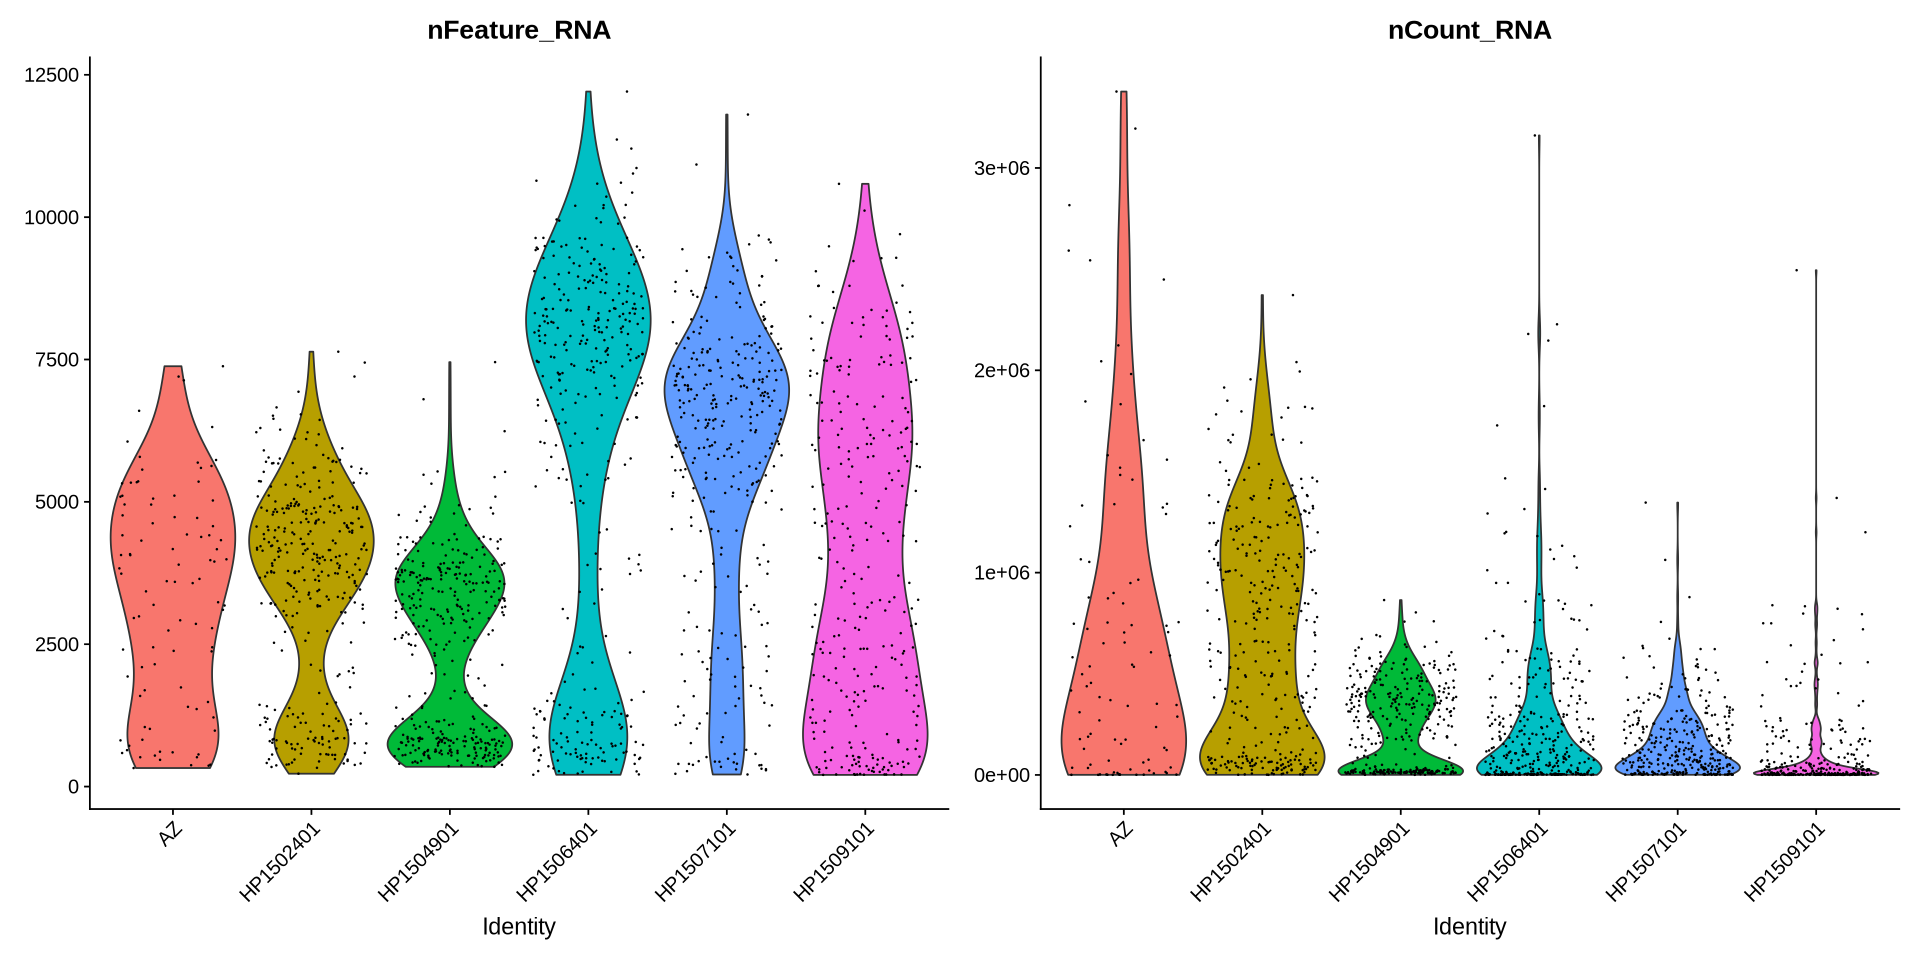

In [43]:
# Visualize QC metrics as a violin plot
VlnPlot(so, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2)

Not sure how to remove the warning message.

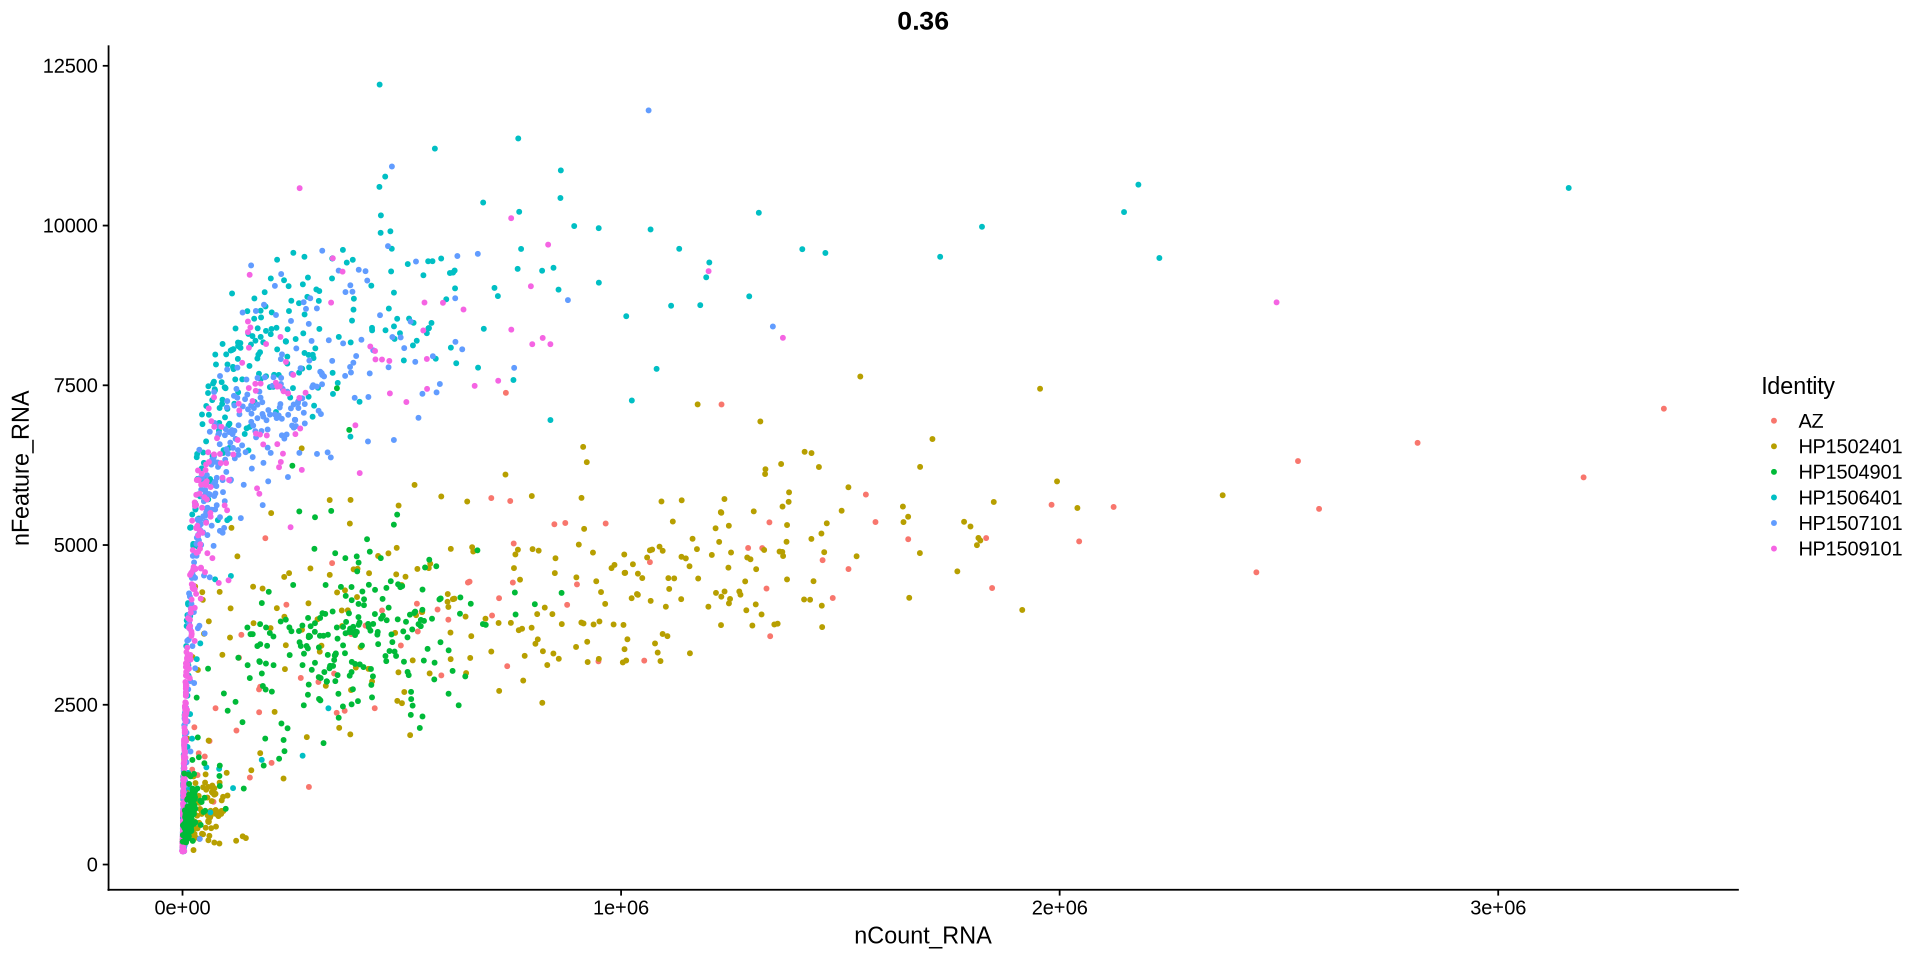

In [45]:
FeatureScatter(so, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

Removing may not be good yet because of the warning above.

In [46]:
subset(so, subset = nFeature_RNA > 200 & nFeature_RNA < 2500)

An object of class Seurat 
20029 features across 590 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 1 layer present: counts

### Normalizing the data

In [48]:
so <- NormalizeData(so)
so

Normalizing layer: counts



An object of class Seurat 
20029 features across 1841 samples within 1 assay 
Active assay: RNA (20029 features, 0 variable features)
 2 layers present: counts, data

### Highly variable features (feature selection)

We only care about genes that vary a lot. We chose top 2000 genes, but we could get away with smaller numbers.

Finding variable features for layer counts

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


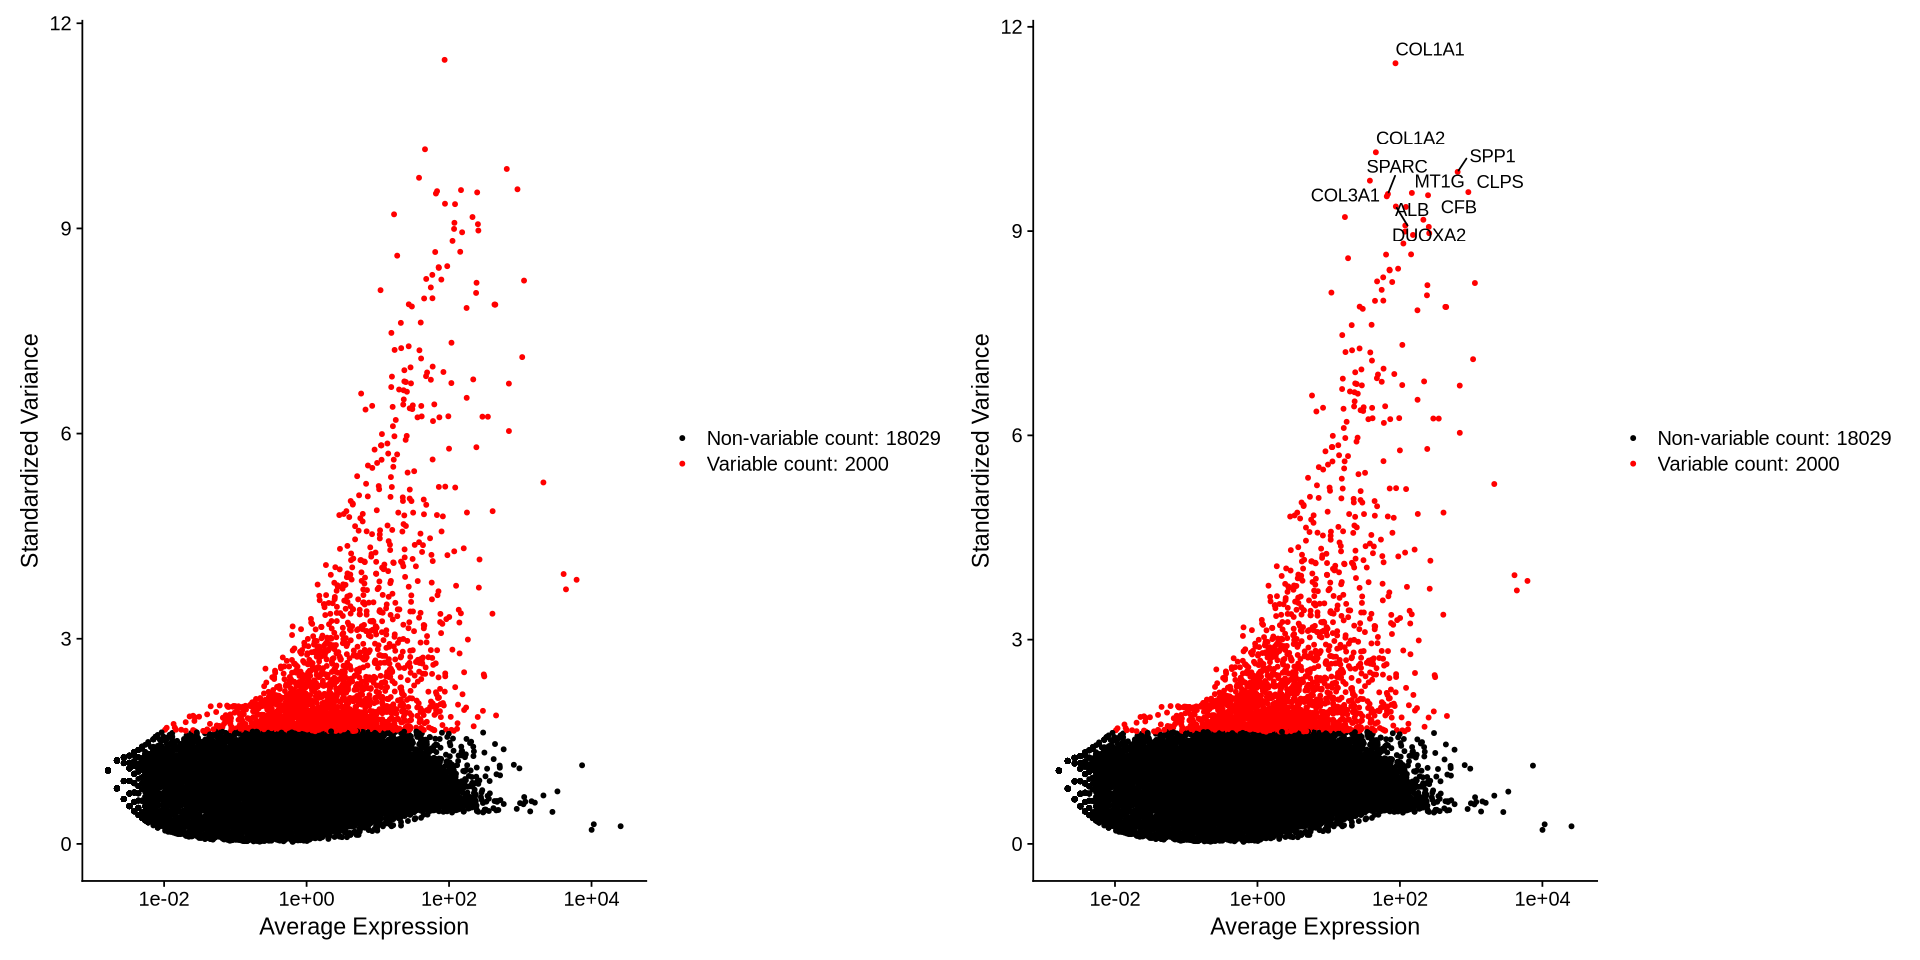

In [50]:
so <- FindVariableFeatures(so, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(so), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(so)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

### Scaling data

Before applying PCA, we have to scale our data so that mean is 0 and variance is 1 for each gene. By default, `ScaleData` only scales highly variable genes, but we want to scale all the genes. This helps us with visualization later.

In [51]:
all.genes <- rownames(so)
so <- ScaleData(so, features = all.genes)

Centering and scaling data matrix



### PCA

PCA allows us to reduce dimension so we can use clustering.

In [52]:
so <- RunPCA(so, features = VariableFeatures(object = so))
print(so[['pca']], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  IFITM3, SERPING1, CTSH, CDC42EP1, PRSS8, RHOC, DHRS3, KRT7, TACSTD2, ZFP36L1 
	   ANXA4, TMSB4X, CLDN1, CD24, LGALS3, S100A11, LCN2, SDC4, LAD1, LITAF 
	   SERPINA3, KRT18, SERPINA5, IFITM2, CLDN10, CFB, TM4SF1, KRT19, MUC20, RBPMS 
Negative:  G6PC2, CRYBA2, PEMT, HEPACAM2, SCGB2A1, RFX6, PCP4, SLC38A4, RGS4, FAM159B 
	   RGS9, PARM1, LOXL4, CRH, FAM105A, PLCE1, EDIL3, PCSK1, RBP4, FAP 
	   SST, SERPINI1, RASD1, NR0B1, MLLT11, DHRS2, C1QL1, MLIP, SPTSSB, IAPP 
PC_ 2 
Positive:  SPARC, COL4A1, NID1, LRRC32, IFITM1, COL1A2, TIMP3, PXDN, BGN, PDGFRB 
	   COL6A2, COL3A1, LAMA4, COL5A1, COL1A1, COL6A3, F2R, SFRP2, TMEM204, IGFBP4 
	   THY1, PTRF, ENG, AEBP1, CDH11, ANGPTL2, MMP2, LHFP, COL15A1, PLXDC1 
Negative:  CD24, KRT8, LCN2, CLDN4, GATM, ELF3, PRSS8, SERPINA3, TACSTD2, SDC4 
	   CFB, REG1A, KRT7, MUC1, SPINK1, ANPEP, RAB11FIP1, AMBP, GSTA1, CD74 
	   KRT18, ANXA4, SERPINA5, LYZ, LAD1, CLDN1, PRSS1, CD44, ADH1C, GGT6 
PC_ 3 
Positive:  TINAGL1, CFTR, CMTM7, SPP1, CCND

PC_ 1 
Positive:  IFITM3, SERPING1, CTSH, CDC42EP1, PRSS8 
Negative:  G6PC2, CRYBA2, PEMT, HEPACAM2, SCGB2A1 
PC_ 2 
Positive:  SPARC, COL4A1, NID1, LRRC32, IFITM1 
Negative:  CD24, KRT8, LCN2, CLDN4, GATM 
PC_ 3 
Positive:  TINAGL1, CFTR, CMTM7, SPP1, CCND1 
Negative:  CTRB1, CTRC, CTRB2, PNLIPRP2, CPA2 
PC_ 4 
Positive:  COL1A2, COL3A1, COL5A1, PDGFRB, COL1A1 
Negative:  RGCC, FLT1, PCAT19, PECAM1, PODXL 
PC_ 5 
Positive:  HADH, NPTX2, PCSK1, PFKFB2, ADCYAP1 
Negative:  ERCC-468.75:mix1-937.5:mix2, AXL, ERCC-29.296875:mix1-43.9453125:mix2, ERCC-468.75:mix1-468.75:mix2, ERCC-234.375:mix1-468.75:mix2 


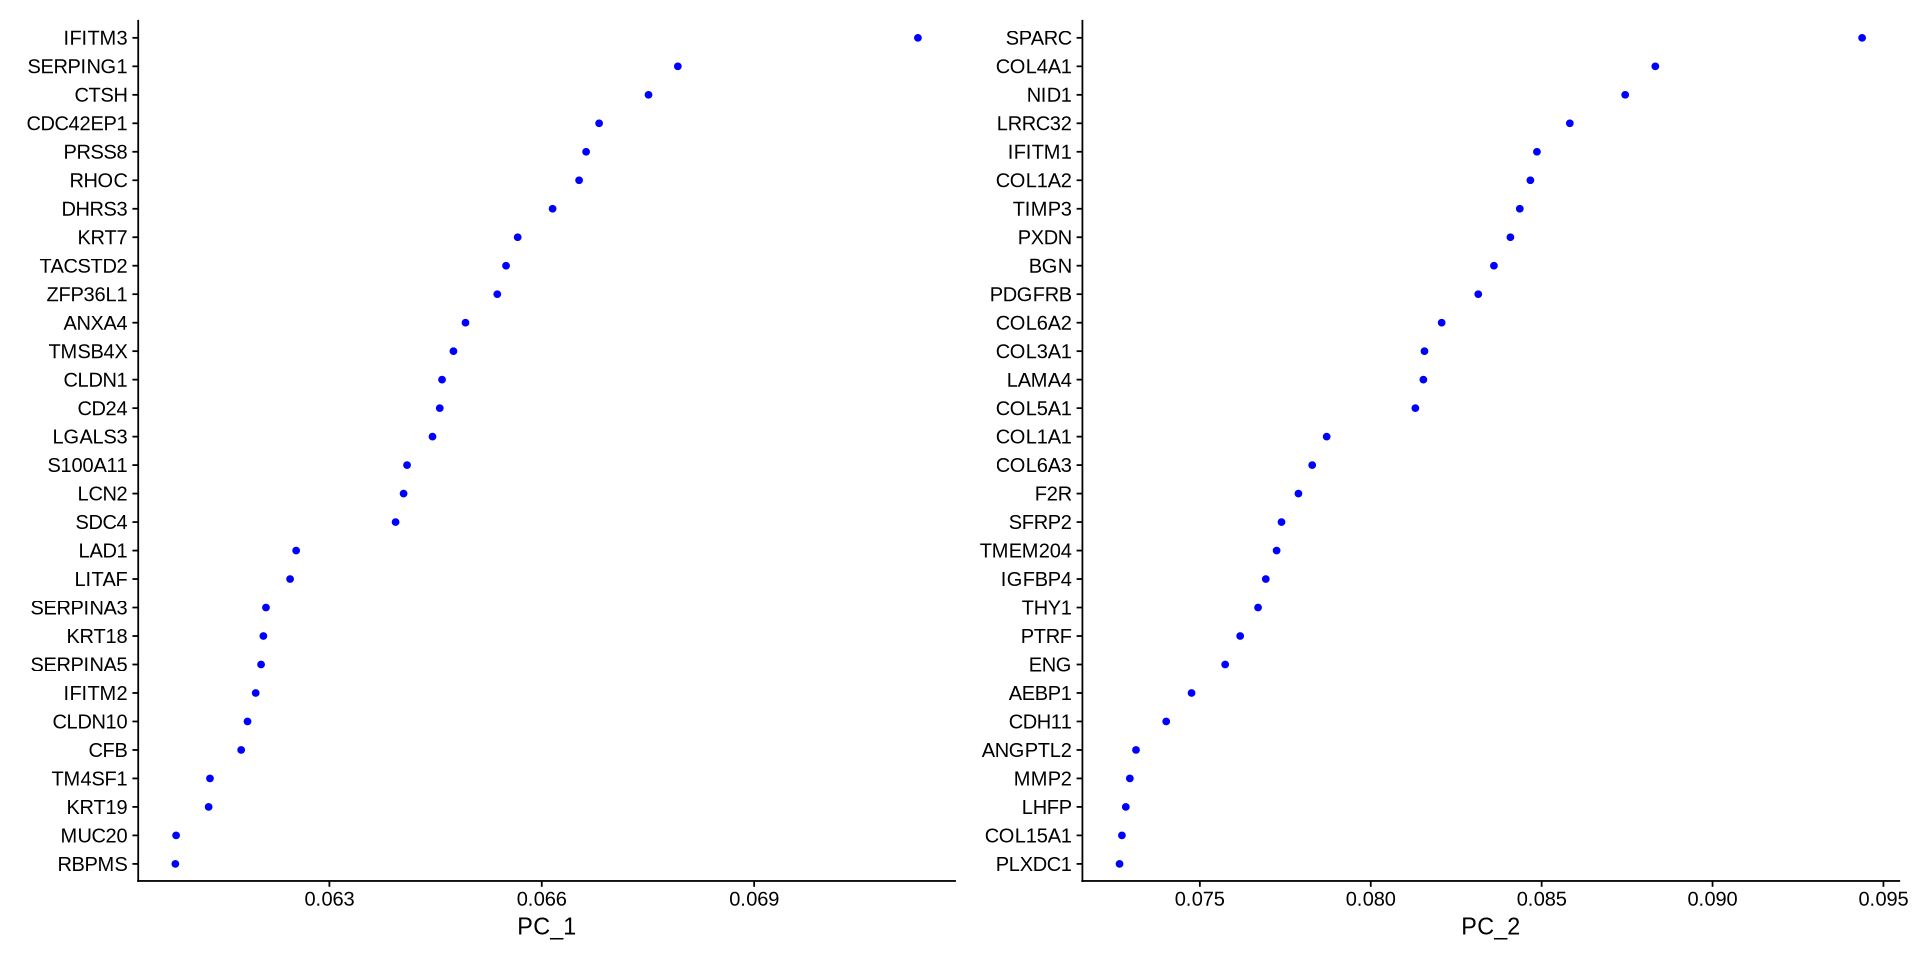

In [53]:
VizDimLoadings(so, dims = 1:2, reduction = "pca")

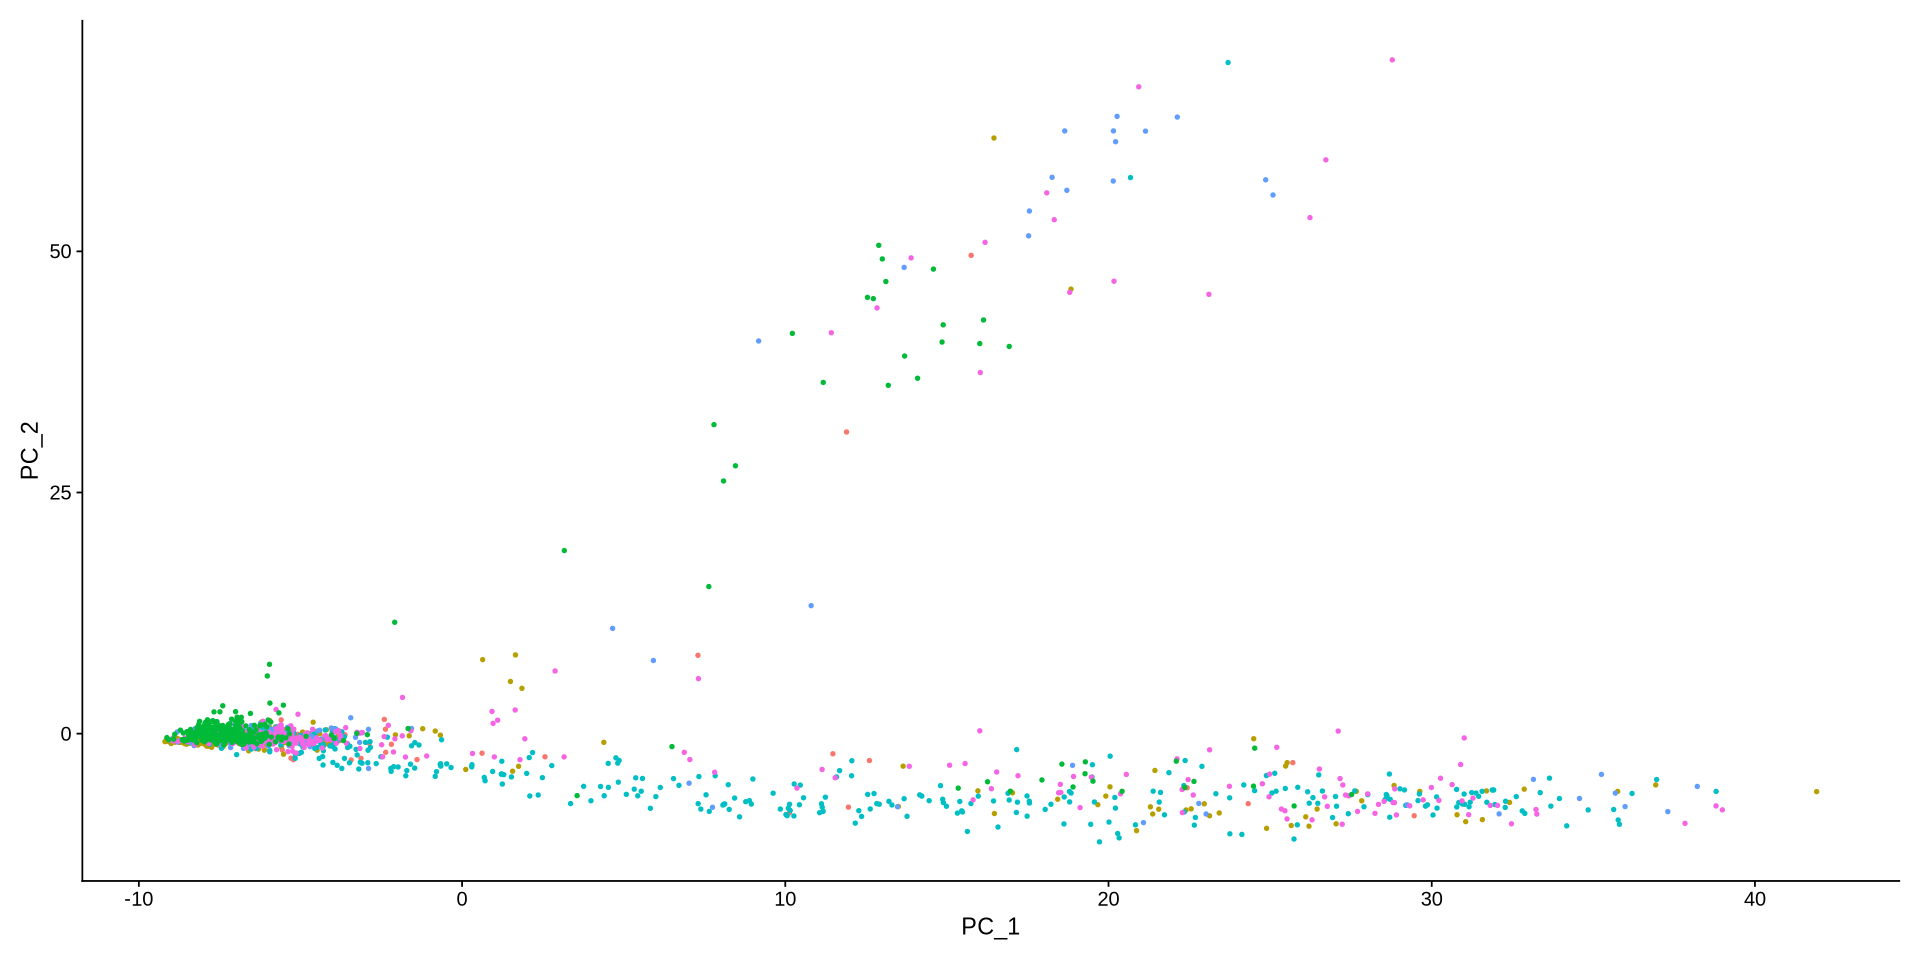

In [54]:
DimPlot(so, reduction = "pca") + NoLegend()

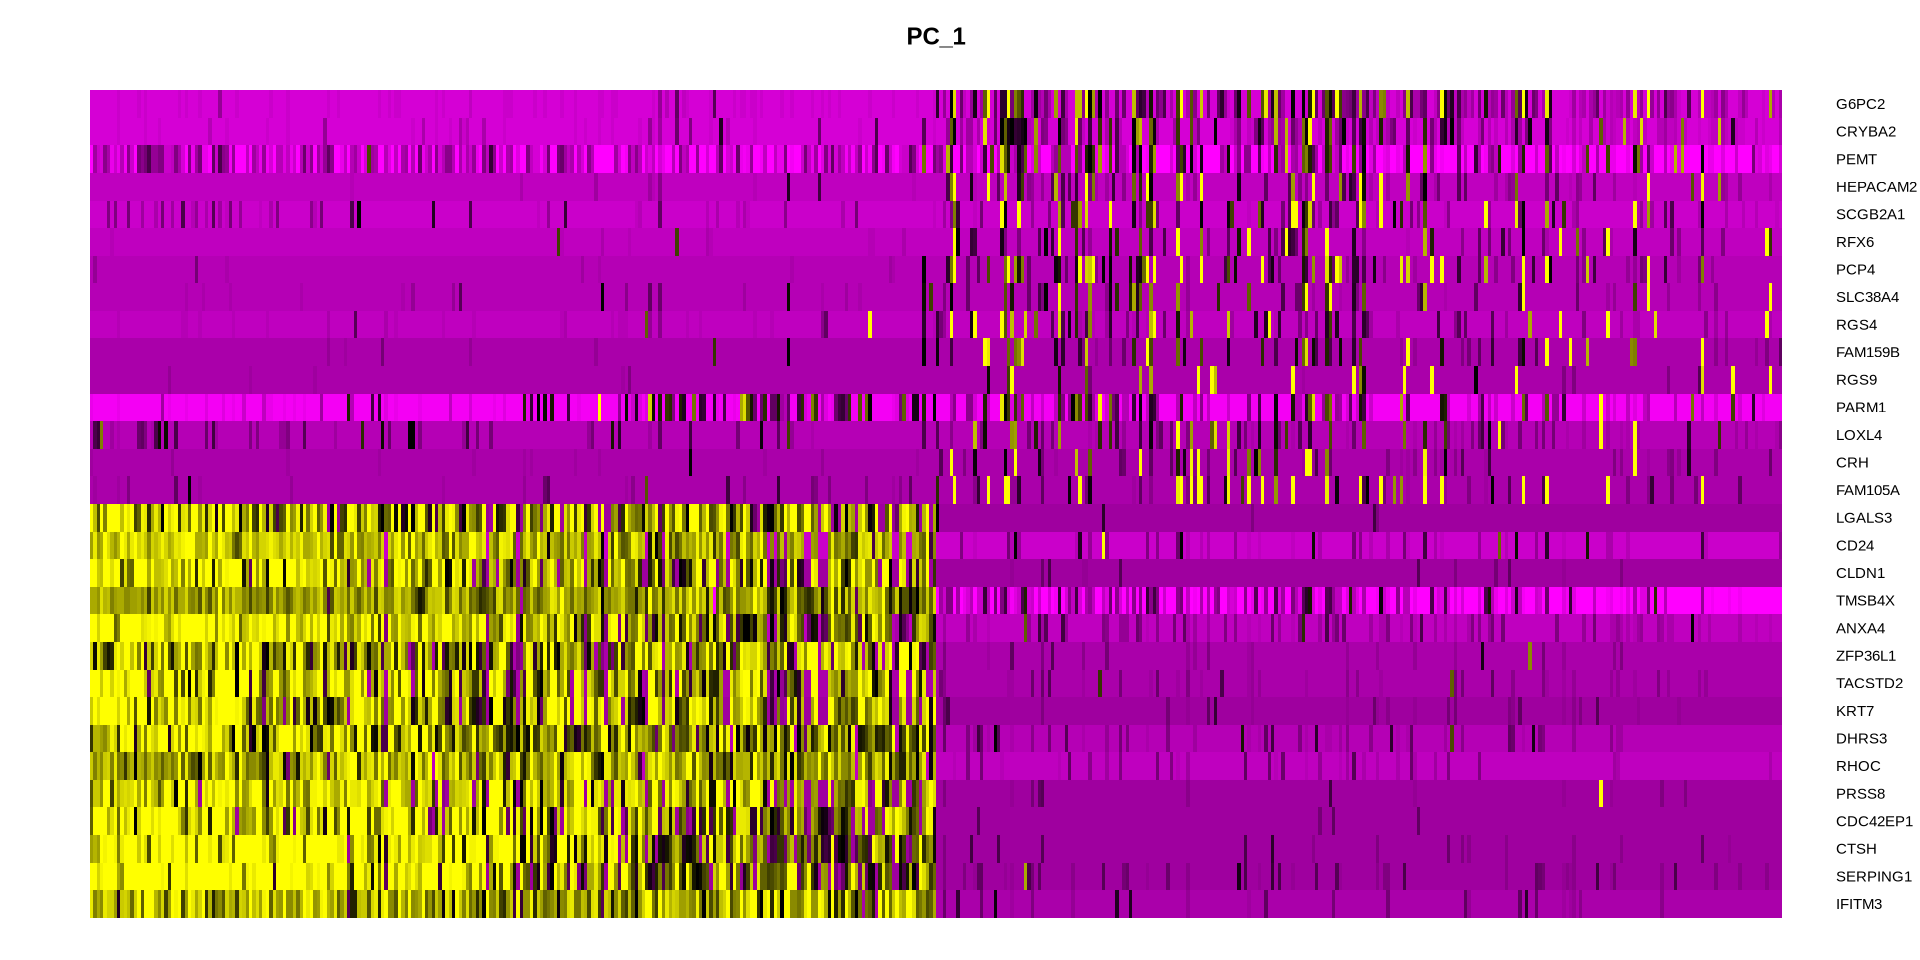

In [55]:
DimHeatmap(so, dims = 1, cells = 500, balanced = TRUE)

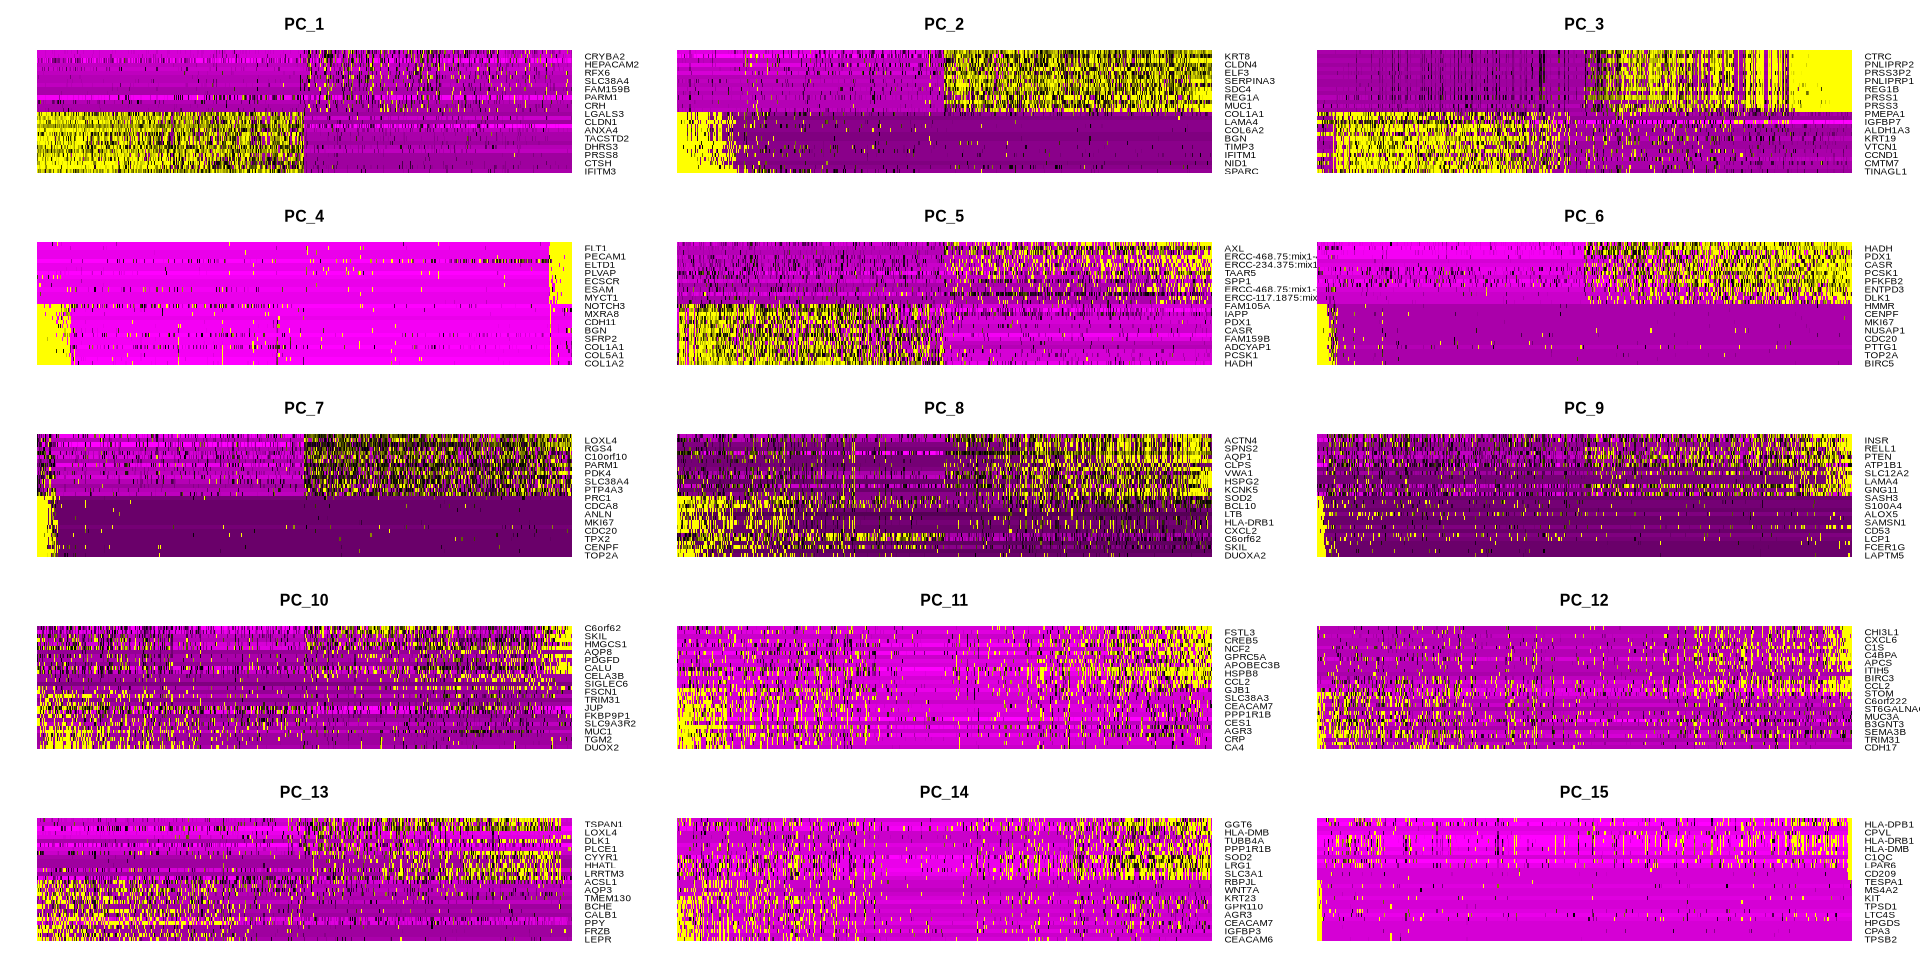

In [56]:
DimHeatmap(so, dims = 1:15, cells = 500, balanced = TRUE)

### Determining the dimensionality of the dataset

Looking at the Elbowplot, we can choose 10 PCs and it should be good. More PCs will just give us more noise.

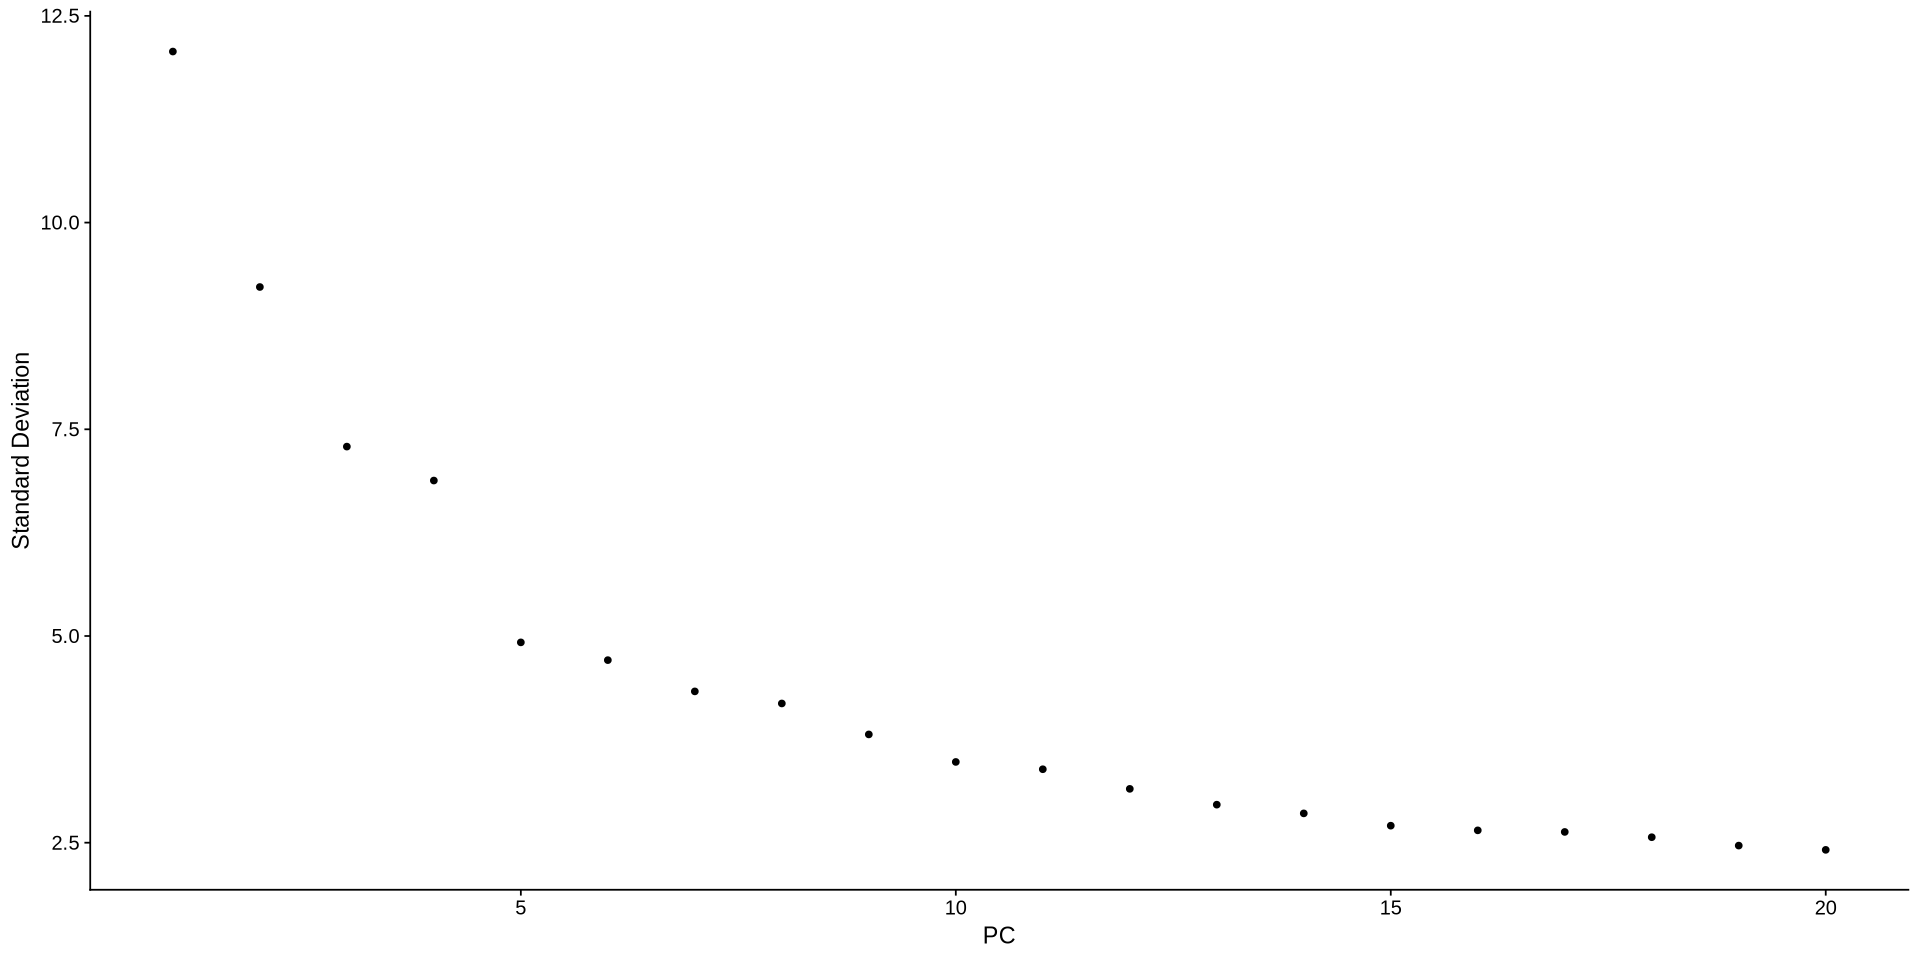

In [57]:
ElbowPlot(so)

In [58]:
so <- FindNeighbors(so, dims = 1:10)
so <- FindClusters(so, resolution = 0.5)
head(Idents(so), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1841
Number of edges: 53535

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8939
Number of communities: 10
Elapsed time: 0 seconds


AZ_A1 AZ_A3 AZ_A4 AZ_B6 AZ_B7 
    0     3     7     3     0 
Levels: 0 1 2 3 4 5 6 7 8 9

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:18:29 UMAP embedding parameters a = 0.9922 b = 1.112

12:18:29 Read 1841 rows and found 10 numeric columns

12:18:29 Using Annoy for neighbor search, n_neighbors = 30

12:18:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:18:29 Writing NN index file to temp file /tmp/RtmpMqqWhW/filed0f16082f49

12:18:29 Searching Annoy index using 1 thread, search_k = 3000

12:18:29 Annoy recall = 100%

12:18:29 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

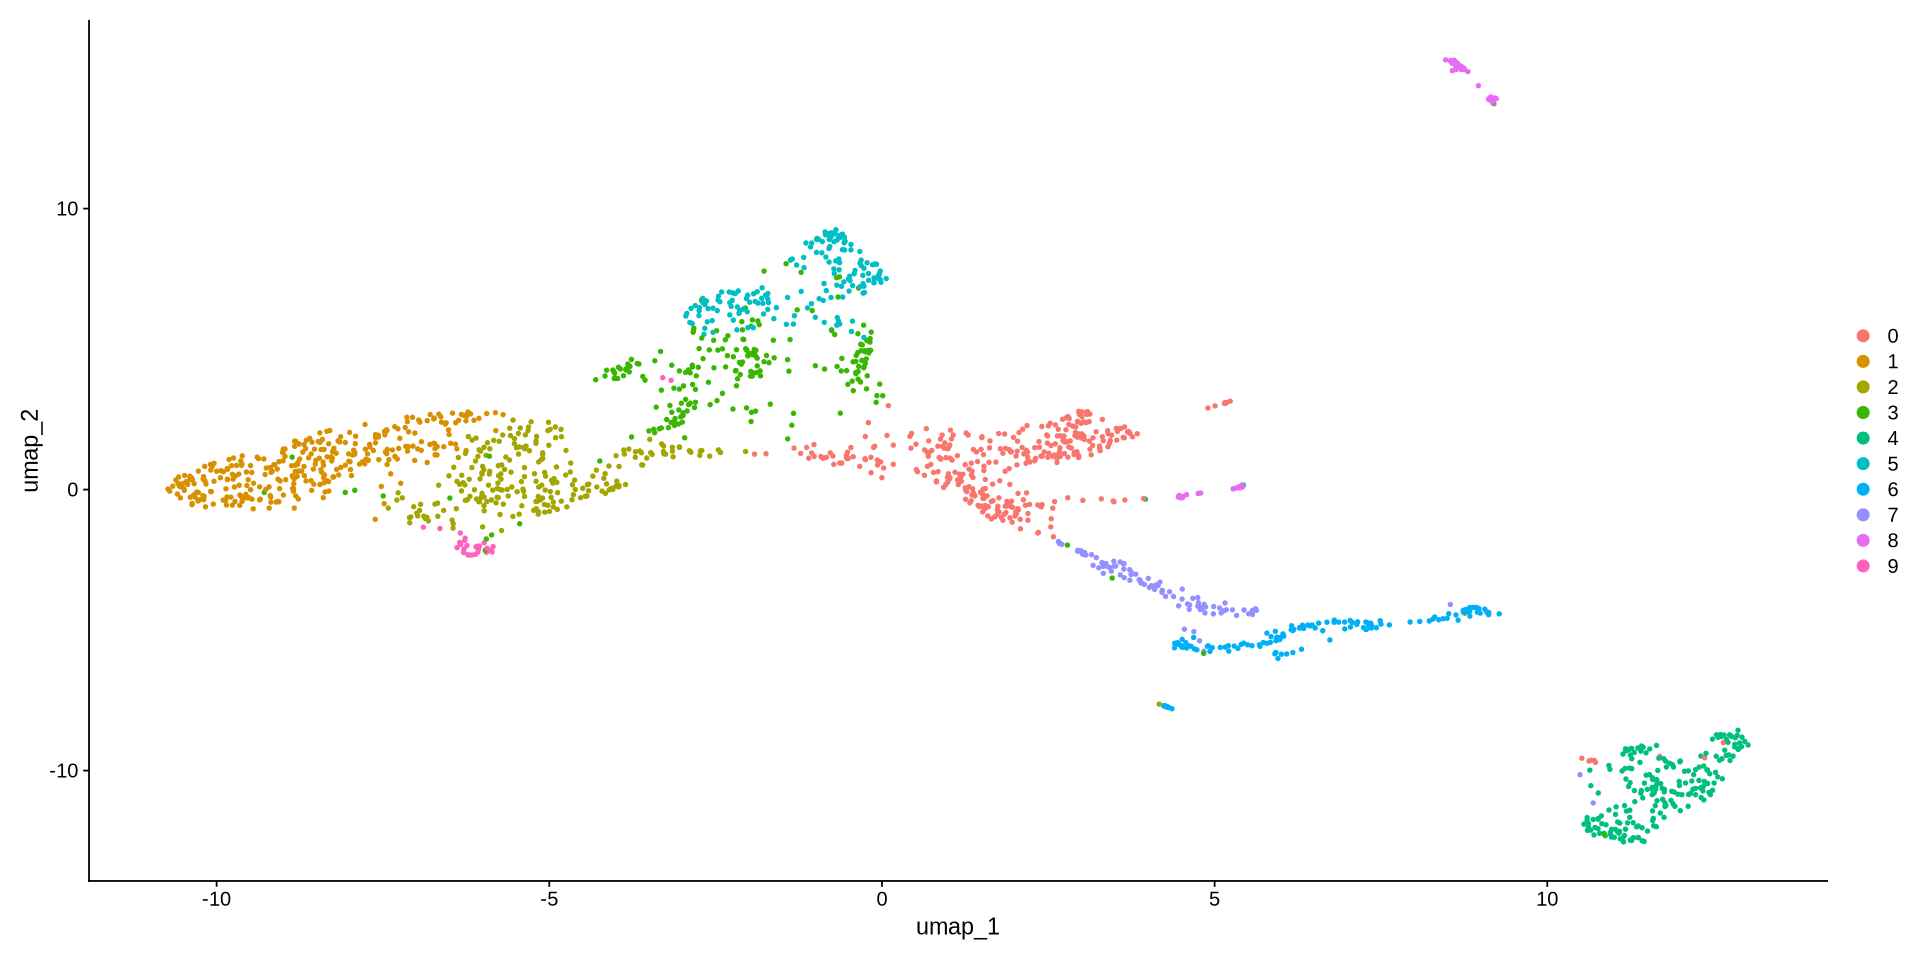

In [59]:
so <- RunUMAP(so, dims = 1:10)
DimPlot(so, reduction = 'umap')

## Getting baron data

In [94]:
# Hint:
# 1. Need to reorder the cells to make them match between count and cell.meta
# 2. Need to select the healthy individuals (and remove the T2D patients)

###########################################################################
# Paper: PMID 27667667
# Data link (available in paper):
# https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-5061
###########################################################################

baron1=read.csv('../data/GSE84133_RAW/GSM2230757_human1_umifm_counts.csv.gz')
baron2=read.csv('../data/GSE84133_RAW/GSM2230758_human2_umifm_counts.csv.gz')
baron3=read.csv('../data/GSE84133_RAW/GSM2230759_human3_umifm_counts.csv.gz')
baron4=read.csv('../data/GSE84133_RAW/GSM2230760_human4_umifm_counts.csv.gz')

In [95]:
head(baron1)

,X,barcode,assigned_cluster,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AA06,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,acinar,0,4,0,0,0,0,0,⋯,0,0,0,0,0,0,2,0,0,1
2,human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,acinar,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,4,0,1,0
3,human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,acinar,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,acinar,0,0,0,0,0,0,0,⋯,1,0,0,0,0,1,3,1,0,0
5,human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,acinar,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,1
6,human1_lib1.final_cell_0006,AATCCCACG-ATTCGACG,acinar,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,0


In [97]:
# Check that the columns are the same before combining rows
all(colnames(baron1)==colnames(baron2))
all(colnames(baron1)==colnames(baron3))
all(colnames(baron1)==colnames(baron4))

[1] TRUE

[1] TRUE

[1] TRUE

In [100]:
baron=rbind(baron1, baron2, baron3, baron4)
rm(baron1,baron2,baron3,baron4)
head(baron)

ERROR: Error in eval(expr, envir, enclos): object 'baron1' not found


In [101]:
cell.meta=baron[,1:3]
colnames(cell.meta)[1]='cell'
head(cell.meta)

,cell,barcode,assigned_cluster
,<chr>,<chr>,<chr>
1,human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,acinar
2,human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,acinar
3,human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,acinar
4,human1_lib1.final_cell_0004,GATGTACACG-TTAAACTG,acinar
5,human1_lib1.final_cell_0005,GAGATTGCGA-GTCGTCGT,acinar
6,human1_lib1.final_cell_0006,AATCCCACG-ATTCGACG,acinar


In [105]:
cell.meta$individual=substr(cell.meta$cell, start=1, stop=6)
head(cell.meta, 3)

,cell,barcode,assigned_cluster,individual
,<chr>,<chr>,<chr>,<chr>
1,human1_lib1.final_cell_0001,GATGACGGAC-GGTGGGAT,acinar,human1
2,human1_lib1.final_cell_0002,GAGCGTTGCT-ACCTTCTT,acinar,human1
3,human1_lib1.final_cell_0003,CTTACGGG-CCATTACT,acinar,human1


In [106]:
table(cell.meta$individual)


human1 human2 human3 human4 
  1937   1724   3605   1303 

In [107]:
count=as.matrix(baron[,-(1:3)])
rm(baron)
head(count)

A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AA06,AAAS,AACS,AACSP1,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,2,0,0,1
0,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,1,4,0,1,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,⋯,1,0,0,0,0,1,3,1,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0,1
0,1,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,0,1,1,1,0


In [108]:
rownames(count)=cell.meta$cell
rownames(cell.meta)=cell.meta$cell
colnames(cell.meta)[3]='celltype'
head(count, 3)

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AA06,AAAS,AACS,AACSP1,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
human1_lib1.final_cell_0001,0,4,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,2,0,0,1
human1_lib1.final_cell_0002,0,0,0,0,0,0,0,0,2,0,⋯,0,0,0,0,0,1,4,0,1,0
human1_lib1.final_cell_0003,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
